# Disney Review Topic Modeling 
#### In natural language processing (NLP), topic modeling clusters documents by topics. I explored three methods:
- Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) 
- Latent Dirichlet Allocation (LDA) 
- ChatGPT Prompt Engineering - Inferring (See notebook here: https://github.com/aimee0317/topic_modeling_Disney_reviews/blob/main/src/ChatGPT_Inferring_Topics.ipynb)

## Load relevant packages 

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import string
import nltk
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import tkinter
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from textblob import TextBlob
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings


alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()
%matplotlib inline
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings('ignore')

/Users/amelia/opt/miniconda3/envs/top_modeling_disney/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/amelia/opt/miniconda3/envs/top_modeling_disney/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/amelia/opt/miniconda3/envs/

## Read and Preprocess the data 
- Ensured consistent spellings 
- Removed digits and punctuation
- Tokenized the text using Regex tokenizer 
    - Tokenization refers to the straightforward process of converting natural text into smaller units called "tokens"
- Removed stopwords 
- Performed stemming and lemmatization 
    - Lemmatization involves substituting a word with its base or root form, known as a lemma. The goal is to reduce different inflected forms to a shared base form. 
    - A lemmatizer utilizes a database of word synonyms and word endings to ensure that only words with similar meanings are combined into a unified token. 
    - Stemming involves reducing a word to its base form by removing affixes, including prefixes and suffixes, or by reducing it to the root form, also referred to as "lemmas".
    - In this project, I used WordNetLemmatizer() and LancasterStemmer() from NLTK. 
    
References:
- https://medium.com/@yashj302/lemmatization-f134b3089429
- https://www.techtarget.com/searchenterpriseai/definition/stemming 
- https://wandb.ai/sauravm/Tokenizers/reports/NLP-Basics-What-is-Tokenization-and-How-Do-You-Do-It---VmlldzoxOTAxNDU2

### Read the data 

In [2]:
disney_df = pd.read_csv("../data/raw/DisneylandReviews.csv")
reviews = disney_df['Review_Text']

In [3]:
reviews  

0        If you've ever been to Disneyland anywhere you...
1        Its been a while since d last time we visit HK...
2        Thanks God it wasn   t too hot or too humid wh...
3        HK Disneyland is a great compact park. Unfortu...
4        the location is not in the city, took around 1...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited Disneyland ...
42653    My eleven year old daughter and myself went to...
42654    This hotel, part of the Disneyland Paris compl...
42655    I went to the Disneyparis resort, in 1996, wit...
Name: Review_Text, Length: 42656, dtype: object

### Ensure spelling consistency 

In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('hk', 'hongkong')
    text = text.replace('hong kong', 'hongkong')
    text = text.replace("n't", " not")
    text = text.replace('n   t', " not")
    text = text.replace('disneyparis', 'disney paris')
    text = text.replace('kowlon', 'kowloon')
    text = text.replace('  ', ' ')
    return text

In [5]:
reviews = reviews.apply(lambda x: preprocess(x))
reviews

0        if you've ever been to disneyland anywhere you...
1        its been a while since d last time we visit ho...
2        thanks god it was not too hot or too humid whe...
3        hongkong disneyland is a great compact park. u...
4        the location is not in the city, took around 1...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited disneyland ...
42653    my eleven year old daughter and myself went to...
42654    this hotel, part of the disneyland paris compl...
42655    i went to the disney paris resort, in 1996, wi...
Name: Review_Text, Length: 42656, dtype: object

### Remove punctuation and digits

In [6]:
def remove_punc(text):
    clean = ''.join([char for char in text if char not in string.punctuation])
    return clean

In [7]:
reviews = reviews.apply(lambda x: remove_punc(x))
reviews

0        if youve ever been to disneyland anywhere youl...
1        its been a while since d last time we visit ho...
2        thanks god it was not too hot or too humid whe...
3        hongkong disneyland is a great compact park un...
4        the location is not in the city took around 1 ...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited disneyland ...
42653    my eleven year old daughter and myself went to...
42654    this hotel part of the disneyland paris comple...
42655    i went to the disney paris resort in 1996 with...
Name: Review_Text, Length: 42656, dtype: object

In [8]:
def remove_digit(text):
    clean = ''.join([i for i in text if not i.isdigit()])
    clean = clean.replace('  ', ' ')
    return clean

In [9]:
reviews = reviews.apply(lambda x: remove_digit(x))
reviews

0        if youve ever been to disneyland anywhere youl...
1        its been a while since d last time we visit ho...
2        thanks god it was not too hot or too humid whe...
3        hongkong disneyland is a great compact park un...
4        the location is not in the city took around ho...
                               ...                        
42651    i went to disneyland paris in july and thought...
42652     adults and child of visited disneyland paris ...
42653    my eleven year old daughter and myself went to...
42654    this hotel part of the disneyland paris comple...
42655    i went to the disney paris resort in with a sm...
Name: Review_Text, Length: 42656, dtype: object

### Tokenize the text

In [10]:
tokenizer = RegexpTokenizer(r'\w+')

In [11]:
reviews_tokenized = reviews.apply(lambda x: tokenizer.tokenize(x.lower()))
reviews_tokenized 

0        [if, youve, ever, been, to, disneyland, anywhe...
1        [its, been, a, while, since, d, last, time, we...
2        [thanks, god, it, was, not, too, hot, or, too,...
3        [hongkong, disneyland, is, a, great, compact, ...
4        [the, location, is, not, in, the, city, took, ...
                               ...                        
42651    [i, went, to, disneyland, paris, in, july, and...
42652    [adults, and, child, of, visited, disneyland, ...
42653    [my, eleven, year, old, daughter, and, myself,...
42654    [this, hotel, part, of, the, disneyland, paris...
42655    [i, went, to, the, disney, paris, resort, in, ...
Name: Review_Text, Length: 42656, dtype: object

### Remove stopwords

In [12]:
nltk_stopwords = pd.Series(stopwords.words("english"))
nltk_stopwords = nltk_stopwords.apply(lambda x: remove_punc(x))
nltk_stopwords = set(nltk_stopwords)

In [13]:
stopwords_700 = pd.read_csv('../EDA/stopwords.txt', header= None, delimiter = "\t")
stopwords_700 = set(stopwords_700[0])

In [14]:
def remove_stopwords(text): 
    stop_words = set(stopwords.words("english"))
    stop_words_customize = {'disney', 'disneyland', 'land', 'park', 'parks', 'world', 'disneyworld', 'disney world', 'one'}
    stop_words_all = nltk_stopwords.union(stopwords_700, stop_words_customize)
    clean = [word for word in text if not word in stop_words_all]
    return clean

In [15]:
reviews_nostop = reviews_tokenized.apply(lambda x: remove_stopwords(x))

In [16]:
reviews_nostop

0        [find, hongkong, similar, layout, walk, street...
1        [last, time, visit, hongkong, time, stay, tomo...
2        [thanks, god, hot, humid, visiting, big, issue...
3        [hongkong, great, compact, unfortunately, bit,...
4        [location, city, took, hour, kowloon, kids, li...
                               ...                        
42651    [went, july, thought, brilliant, visited, hote...
42652    [adults, child, visited, beginning, feb, absol...
42653    [eleven, year, old, daughter, went, visit, son...
42654    [hotel, part, complex, wonderful, place, famil...
42655    [went, resort, small, child, minute, enter, tr...
Name: Review_Text, Length: 42656, dtype: object

### Lemmatization and stemming
- Instead of using WordNetLemmatizer alone, I added part of speech tagging to yield better results. 

In [17]:
def pos_lemmatize(text):
    lem = WordNetLemmatizer()
    for word, tag in nltk.pos_tag(text):
        if tag.startswith("NN"):
            yield lem.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield lem.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield lem.lemmatize(word, pos='a')
        else:
            yield word

In [18]:
def final_lemmatizer(text):
    lem_text = ' '.join(pos_lemmatize(text))
    return lem_text

In [19]:
reviews_lemmatized = reviews_nostop.apply(lambda x: final_lemmatizer(x))
reviews_lemmatized

0        find hongkong similar layout walk street famil...
1        last time visit hongkong time stay tomorrowlan...
2        thanks god hot humid visit big issue shadei ar...
3        hongkong great compact unfortunately bit maint...
4        location city take hour kowloon kid like fine ...
                               ...                        
42651    go july think brilliant visited hotel stay new...
42652    adult child visited begin feb absolute fantast...
42653    eleven year old daughter go visit son london d...
42654    hotel part complex wonderful place family kid ...
42655    go resort small child minute enter transport t...
Name: Review_Text, Length: 42656, dtype: object

In [20]:
stemmer = LancasterStemmer()

def text_stemmer(text):
    stem_text = ''.join([stemmer.stem(i) for i in text])
    return stem_text

In [21]:
reviews_clean = reviews_lemmatized.apply(lambda x: text_stemmer(x))
reviews_clean

0        find hongkong similar layout walk street famil...
1        last time visit hongkong time stay tomorrowlan...
2        thanks god hot humid visit big issue shadei ar...
3        hongkong great compact unfortunately bit maint...
4        location city take hour kowloon kid like fine ...
                               ...                        
42651    go july think brilliant visited hotel stay new...
42652    adult child visited begin feb absolute fantast...
42653    eleven year old daughter go visit son london d...
42654    hotel part complex wonderful place family kid ...
42655    go resort small child minute enter transport t...
Name: Review_Text, Length: 42656, dtype: object

In [22]:
reviews_clean[0:10]

0    find hongkong similar layout walk street famil...
1    last time visit hongkong time stay tomorrowlan...
2    thanks god hot humid visit big issue shadei ar...
3    hongkong great compact unfortunately bit maint...
4    location city take hour kowloon kid like fine ...
5    anaheim tokyo feel hongkong small call way rid...
6    great place day wo know obviously go daughter ...
7    think intro magic little one attraction comple...
8    feel let placethe train fantastic past station...
9    talk say childhood dream come true start entra...
Name: Review_Text, dtype: object

## Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) 
**Algorithm Steps**
- Transform the space based on density / sparsity 
- Create a minimum spanning tree using a distance-weighted graph
- Form a cluster hierarchy by connecting components
- Condense the cluster hierarchy based on minimum cluster size.
- Extract the stable clusters from the condensed tree.

**NOTE:** Due to limited computational power on my local machine, I used first 10,000 lines of data for HDBSCAN. Cloud services can be utilized to increase computational power in the future. 

### Word Embeddings
The sentence transfer model, all-distilroberta-v1, maps sentences and paragraphs into a dense vector space of 768 dimensions, making it suitable for tasks such as clustering or semantic search. 

In [23]:
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
embeddings = model.encode(reviews_clean[0:10000])

In [24]:
embeddings

array([[-0.01177758, -0.00601741, -0.03364545, ..., -0.05637879,
        -0.02640001, -0.01771655],
       [ 0.00057895, -0.05718949, -0.00451084, ..., -0.00899257,
        -0.0079791 ,  0.03817742],
       [ 0.03586723, -0.02685464, -0.02512768, ..., -0.03737215,
         0.02771717, -0.00329971],
       ...,
       [ 0.01897289,  0.00949204, -0.01469616, ..., -0.01598231,
         0.04834994,  0.02745166],
       [ 0.02736183,  0.02605095,  0.01172643, ..., -0.02204102,
         0.03782763,  0.03224099],
       [ 0.01359811,  0.036863  , -0.05302053, ...,  0.05390039,
        -0.02048063,  0.02469895]], dtype=float32)

### Dimension reduction using UMAP
UMAP is a general purpose manifold learning and dimension reduction algorithm.

In [25]:
umap_embeddings = umap.UMAP(n_neighbors=5, 
                            n_components=5,
                            metric='euclidean').fit_transform(embeddings)

Use UMAP to reduce the 768 dimensions of the embedded review text using the "all-distilroberta-v1" model to 5 dimensions. 

In [26]:
umap_embeddings_df = pd.DataFrame(umap_embeddings, columns=['1st dimension', '2nd dimension', '3rd dimension', '4th dimension', '5th dimension'])
umap_embeddings_df.head(10)

,1st dimension,2nd dimension,3rd dimension,4th dimension,5th dimension
0,1.309711,0.349908,1.273069,2.262674,6.493268
1,3.015415,1.842505,0.522373,1.650187,7.182323
2,8.221949,1.156715,0.739283,3.181079,5.727958
3,1.102312,0.993864,1.234652,1.470296,6.773607
4,1.459376,0.460917,1.298073,2.454244,8.299394
5,2.027029,1.708335,1.337616,1.727674,6.047011
6,8.315440,1.079930,1.823015,3.099753,7.419685
7,1.507141,0.996714,1.329077,1.687159,6.390192
8,6.981137,2.080045,1.412081,2.506202,6.034598
9,2.747465,1.065035,1.196853,1.574077,6.512585


### Apply HDBSCAN for clustering and choose the parameters
**Parameters**: 
- **`cluster_selection_method`** has two options, `leaf` and Excess of Mass (`eom`) with `eom` being the default. Excess of Mass tends to pick one or two large clusters and then a number of small extra clusters but this is not the result I'd like to see so I use `leaf` instead. The `leaf` method will select leaf nodes from the tree and tends many small homogeneous clusters.    
- **`min_cluster_size`** is the smallest size grouping that I wish to consider a cluster. I set it to be 50.  
- **`min_samples`**: The larger the value of `min_samples`, the more conservative the clustering and more points will be identified as noise, and clusters will be restricted to more dense areas. I set a small `min_samples` so that I can get enough clusters. 
- **`alpha`**: By default, `alpha` is set to be 1 and I use the default because a larger `alpha` will make clustering more conservative. 
- **`cluster_selection_epsilon`**: Epsilon is the radius of the circle to be created around each data point to check the density and has a default value of 0 in Scikit Learn. I use the default because a cluster with not many data points is still meaningful to the analysis.
- **`metric`**: The metric to use when calculating distance between points and 'euclidean' is the default. 

<br>References: https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

In [27]:
cluster = hdbscan.HDBSCAN(min_cluster_size=50,
                          metric='euclidean', 
                          min_samples=1,
                          cluster_selection_method='leaf').fit(umap_embeddings)

### Visualize the clusters on a 2D graph 
- I further reduced the embedded reviews/documents to 2 dimensions in order to form a 2D graph. 
- From the graph, we can see many points are in gray which means the reviews/documents are considered noise by the model. 

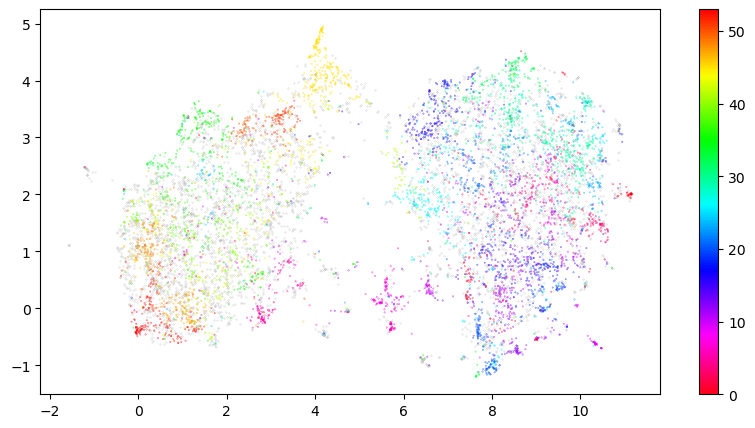

In [28]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='euclidean').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [29]:
doc = pd.DataFrame(reviews_clean[0:10000])
doc['Topic'] = cluster.labels_
doc['Doc_ID'] = range(len(doc))

In [30]:
doc

,Review_Text,Topic,Doc_ID
0,find hongkong similar layout walk street famil...,-1,0
1,last time visit hongkong time stay tomorrowlan...,-1,1
2,thanks god hot humid visit big issue shadei ar...,20,2
3,hongkong great compact unfortunately bit maint...,43,3
4,location city take hour kowloon kid like fine ...,47,4
...,...,...,...
9995,truly magical place christmas enhances experie...,0,9995
9996,delight join folk experience extraordinary tim...,-1,9996
9997,visitied day fine weather go decemberhowever v...,-1,9997
9998,far happy place earth sure long line high pric...,-1,9998


In [31]:
docs_per_topic = doc.groupby(['Topic'], as_index = False).agg({'Review_Text': ' '.join})

In [32]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [33]:
tf_idf, count = c_tf_idf(docs_per_topic.Review_Text.values, m=len(reviews_clean[0:10000]))

In [34]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Review_Text
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Review_Text": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [35]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(doc); topic_sizes.head(11)

,Topic,Size
0,-1,4673
30,29,297
46,45,284
27,26,205
17,16,184
6,5,178
21,20,165
12,11,154
36,35,153
48,47,145


### Inferring topics clustered by HDBSCAN
- Topic -1 is noise. HDBSCAN considered 4,980 points as noises. 
- Topic 29, 45, 26, 16, 5, 20, 11, 35, 47 and 23 are the largest clusters the algorithm has identified. 
**Inferring semantic topics**
- `Topic 29`: fire work 
- `Topic 45`: family members 
- `Topic 26`: disappointments 
- `Topic 16`: Disney Characters 
- `Topic 5`:  small, size 
- `Topic 20`: line, queue 
- `Topic 11`: happy, worth visiting 
- `Topic 35`: China, countries 
- `Topic 47`: adults and children, enjoy 
- `Topic 23`: Children, age 

In [36]:
for i in topic_sizes.Topic.values[1:11]: 
    print(f'Five random reviews for the top topics #{i}')
    print(doc.loc[doc.Topic == i, ['Review_Text']].sample(10).values)
    print('\n')

Five random reviews for the top topics #29
[['amaze firework nightdont miss itkids enjoy therefood ok miss parade goback fallowing day wish back']
 ['place traveler contain game child adult join everynight firework presentation excellent place traveler']
 ['great ive visit type game fun age watch felt real visit place']
 ['awesome parade castle light ride family friend felt delighted long time']
 ['nice spread activity thrill ride attraction amaze fully enjoy definitely need alteast day enjoy attraction ready walk facility attraction parade nice child enjoy']
 ['last may early map decide ride like try show like watch able maximize stay sure premise castle firework start best view afford pay fast pas ticket wo waste time wait linestroller rental pricey bring stroller kid toddler']
 ['ride great cater young kid like maybe great attraction view plus train ride hear feel fun show theater play sure give full day miss especially fireworks night wear comfortable extra clothes case wet definit

## Latent Dirichlet Allocation (LDA) 

The LDA model is based on the Dirichlet probability distribution. It assumes that documents sharing similar topics will utilize a common set of words, and latent topics can be discovered by identifying groups of words that consistently co-occur across the corpus. The model also assumes that each document belongs to a fixed number (K) of topics and initially assigns each word to one of the K topics randomly. Through iterative processes, the model improves the assignments until it reaches a steady state where the topic assignment becomes satisfactory. It is important to note that the model only assigns words to topics, and the interpretation of the topics is subjective.

<br>`CountVectorizer` converts a collection of text documents to a matrix of token counts. 
- `max_df` is default to be 1. I set it at 0.95 to ignore words appear in 95% of the documents because they appear to frequently and may be corpus-specific stop words. 
- `min_df` is default to be 1. I set it at 2 to ignore words that appear in less than 2 documents because they might be to specific to that particular document/review. 
-  `stop_words='english'` is to remove English stop words, such as "the" and "a."

<br> Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [37]:
data = doc.Review_Text.values.tolist()

In [38]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [39]:
dtm = cv.fit_transform(data)

### Fit the LDA model 
`n_components=10` to set the number of topics at 10. It's the default setting and I believe 10 is a reasonable amount of topics.

In [40]:
LDA = LatentDirichletAllocation(n_components=10, random_state=123)

In [41]:
LDA.fit(dtm)

LatentDirichletAllocation(random_state=123)

In [42]:
LDA.components_

array([[0.10000665, 0.10004065, 0.10002101, ..., 0.1       , 0.1       ,
        0.10002772],
       [0.1       , 0.10002826, 0.1000154 , ..., 0.1       , 0.10001068,
        0.1       ],
       [0.1       , 0.10002399, 2.49721213, ..., 0.10001403, 0.10000414,
        0.1       ],
       ...,
       [0.10001859, 0.10001246, 4.25452725, ..., 0.10000457, 0.10000575,
        0.91279802],
       [0.10001072, 0.10000373, 0.10003355, ..., 0.10001327, 0.10000074,
        0.10000714],
       [0.10000834, 0.10000651, 2.60822494, ..., 2.91063021, 0.14619041,
        0.10004074]])

### Print out top words for each topic
I print out top 15 words for each topic to see if I can get some information about the semantic topics but it's not easy to infer. 

In [43]:
for index,topic in enumerate(LDA.components_):
    print(f'The top 15 words for #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

The top 15 words for #0
['trip', 'parade', 'close', 'train', 'stay', 'make', 'visit', 'old', 'experience', 'ride', 'year', 'hotel', 'time', 'day', 'hongkong']


The top 15 words for #1
['picture', 'universal', 'fun', 'bay', 'sunny', 'station', 'character', 'christmas', 'visit', 'love', 'mouse', 'mtr', 'hongkong', 'mickey', 'train']


The top 15 words for #2
['crowd', 'kid', 'long', 'line', 'place', 'time', 'visit', 'small', 'child', 'people', 'ride', 'hongkong', 'staff', 'food', 'queue']


The top 15 words for #3
['fun', 'open', 'line', 'close', 'time', 'big', 'great', 'day', 'attraction', 'like', 'mountain', 'visit', 'hongkong', 'small', 'ride']


The top 15 words for #4
['hongkong', 'great', 'visit', 'queue', 'hour', 'small', 'fun', 'minute', 'food', 'long', 'line', 'day', 'wait', 'ride', 'time']


The top 15 words for #5
['small', 'gulch', 'mickey', 'day', 'queue', 'kid', 'mystic', 'grizzly', 'like', 'story', 'time', 'toy', 'space', 'mountain', 'ride']


The top 15 words for #6
['ch

In [44]:
topic_results = LDA.transform(dtm)

In [45]:
doc['LDA_Topic'] = topic_results.argmax(axis=1)

In [46]:
doc.head(10)

,Review_Text,Topic,Doc_ID,LDA_Topic
0,find hongkong similar layout walk street famil...,-1,0,3
1,last time visit hongkong time stay tomorrowlan...,-1,1,5
2,thanks god hot humid visit big issue shadei ar...,20,2,6
3,hongkong great compact unfortunately bit maint...,43,3,3
4,location city take hour kowloon kid like fine ...,47,4,7
5,anaheim tokyo feel hongkong small call way rid...,-1,5,2
6,great place day wo know obviously go daughter ...,-1,6,7
7,think intro magic little one attraction comple...,-1,7,9
8,feel let placethe train fantastic past station...,26,8,4
9,talk say childhood dream come true start entra...,24,9,9


In [47]:
doc.to_csv('../data/topics.csv') #Save the clustering results by HDBSCAN and LDA for ChatGPT prompt engineering

### Inferring topics clustered by LDA
After look at the top 15 words per topic, I cannot identify semantic topics so I print out 10 random samples from each topic to infer. 
<br>**Inferring semantic topics**
- `Topic 0`: Countries and cities 
- `Topic 1`: Train, travel
- `Topic 2`: Food, rides 
- `Topic 3`: Small, fun experience 
- `Topic 4`: Rides, long line, queue 
- `Topic 5`: time, timing 
- `Topic 6`: Character, tour, travel, attraction 
- `Topic 7`: Recommend, worth visiting 
- `Topic 8`: family, best, fantastic 
- `Topic 9`: Travel, ticket, rides, directions

In [48]:
i = 0
while i < len(doc.LDA_Topic.unique()):
    print(f'Five random reviews for topic #{i}')
    print(doc.loc[doc.LDA_Topic == i, ['Review_Text']].sample(10).values)
    print('\n')
    i += 1

Five random reviews for topic #0
[['europe well thank hongkong match perfectly leave usa florida california florida beat match look original california florida fun junlge epcot studio fantasy al reachable roadl back hongkong say fight ocean well someting nice ocean ocean see competition bentley roll royce matter taste education kid endlessly fun experience entrance expert year silver card far cheap family comeptitors family cost money thrill nice street still street usa fill chinese hongkong miss']
 ['see state hongkong make difference especially child welcome spring entrance enthralls mass child clean bowl entry toy train internal stationmore']
 ['year old son single day perfect saw go ride eat laugh photo buzz light year age day maybe old kid day mess art ultra keen magic happen']
 ['small easily complete ride day crowd week weekend tolerable customer service par expand sooner exciting']
 ['first visit beautiful clean see sightsee hongkong wait untill dark see lightshow']
 ['way deci